# Recipe: Cognitive Services - Multivariate Anomaly Detection 
This recipe shows how you can use SynapseML and Azure Cognitive Services on Apache Spark for multivariate anomaly detection. Multivariate anomaly detection allows for the detection of anomalies among many variables or timeseries, taking into account all the inter-correlations and dependencies between the different variables. In this scenario, we use SynapseML to train a model for multivariate anomaly detection using the Azure Cognitive Services, and we then use to the model to infer multivariate anomalies within a dataset containing synthetic measurements from three IoT sensors. 

To learn more about the Anomaly Detector Cognitive Service please refer to [ this documentation page](https://docs.microsoft.com/en-us/azure/cognitive-services/anomaly-detector/). 

### Prerequisites
- An Azure subscription - [Create one for free](https://azure.microsoft.com/en-us/free/)

### Setup
#### Create an Anomaly Detector resource
Follow the instructions below to create an `Anomaly Detector` resource using the Azure portal or alternatively, you can also use the Azure CLI to create this resource.

- In the Azure Portal, click `Create` in your resource group, and then type `Anomaly Detector`. Click on the Anomaly Detector resource.
- Give the resource a name, and ideally use the same region as the rest of your resource group. Use the default options for the rest, and then click `Review + Create` and then `Create`.
- Once the Anomaly Detector resource is created, open it and click on the `Keys and Endpoints` panel on the left. Copy the key for the Anomaly Detector resource into the `ANOMALY_API_KEY` environment variable, or store it in the `anomalyKey` variable in the cell below.


#### Create a Storage Account resource
In order to save intermediate data, you will need to create an Azure Blob Storage Account. Within that storage account, create a container for storing the intermediate data. Make note of the container name, and copy the connection string to that container. You will need this later.  


#### Enter your service keys
Let's start by adding your Anomaly Detector resource key and location.

In [ ]:
import os

anomalyKey =  os.getenv("ANOMALY_API_KEY")
assert anomalyKey is not None, "Please set the environment variable ANOMALY_API_KEY to your Anomaly Detector API key"

location = "eastus" # This is the location of the anomaly detector resource that you created

Now, lets enter the name of the container you created, as well as the connection string.

In [ ]:
containerName = "intermediate-data-container-name" # Replace this with the name of the container you created
connectionString = os.getenv("BLOB_CONNECTION_STRING") # Paste the connection string to your blob storage container here
assert connectionString is not None, "Please set the environment variable BLOB_CONNECTION_STRING to the connection string to your Azure storage account"

Let's import all the necessary modules, and set up our spark session.

In [ ]:
import numpy as np
import pyspark
from pyspark.sql.functions import col
from pyspark.sql.functions import lit
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

spark = pyspark.sql.SparkSession.builder.appName("MyApp") \
            .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5") \
            .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
            .getOrCreate()
import synapse.ml

Now, let's read our data into a Spark DataFrame.

In [ ]:
df = spark.read.format("csv").option("header", "true").load("wasbs://publicwasb@mmlspark.blob.core.windows.net/MVAD/sample.csv")

df = df.withColumn("sensor_1", col("sensor_1").cast(DoubleType())) \
    .withColumn("sensor_2", col("sensor_2").cast(DoubleType())) \
    .withColumn("sensor_3", col("sensor_3").cast(DoubleType()))
df = df.drop('_c0')

# Let's inspect the dataframe:
df.show()

We can now create an `estimator` object, which will be used to train our model. In the cell below, we specify the start and end times for the training data. We also specify the input columns to use, and the name of the column that contains the timestamps. 

In [ ]:
from synapse.ml.cognitive import *

trainingStartTime = "2020-06-01T12:00:00Z"
trainingEndTime = "2020-07-02T17:55:00Z"
intermediateSaveDir = "intermediateData" 
timestampColumn = "timestamp"
inputColumns = ["sensor_1", "sensor_2", "sensor_3"]


estimator = (FitMultivariateAnomaly()
    .setSubscriptionKey(anomalyKey)
    .setLocation("eastus")
    .setStartTime(trainingStartTime)
    .setEndTime(trainingEndTime)
    .setContainerName(containerName)
    .setIntermediateSaveDir(intermediateSaveDir)
    .setTimestampCol(timestampColumn)
    .setInputCols(inputColumns)
    .setConcurrency(5)
    .setSlidingWindow(200)
    .setConnectionString(connectionString)
     )

Now that we have created the `estimator`, let's fit it to the data:

In [ ]:
model = estimator.fit(df)

Once the training is done, we can now use the model for inference. The code in the next cell specifies the start and end times for the data we would like to detect the anomlies in. It will then show the results.

In [ ]:
inferenceStartTime = "2020-07-02T18:00:00Z"
inferenceEndTime = "2020-07-06T05:15:00Z"
result = (model
    .setStartTime(inferenceStartTime)
    .setEndTime(inferenceEndTime)
    .setOutputCol("results")
    .setErrorCol("errors")
    .setInputCols(inputColumns)
    .setTimestampCol(timestampColumn)
    .transform(df)
     )
result.show()

When we called `.show()` in the previous cell, it showed us the entire dataframe from the first row. The results were all `null` because they were not in the range of the inferrence window.

To show the results only for the infferred data, lets only select the `timestamp` column, the `isAnomaly` column, the `severity` column, in addition to the input columns. We can then order the rows in the dataframe by ascending order, and filter it to only show the rows that are in the range of the inference window. In our case `inferenceEndTime` is the same as the last row in the dataframe, so can ignore that. 

Finally, to be able to better plot the results, lets convert the Spark dataframe to a Pandas dataframe.

This is what the next cell does:

In [ ]:
rdf = result.select("timestamp",*inputColumns,"results.isAnomaly", "results.severity").orderBy('timestamp', ascending=True).filter(col('timestamp') >= lit(inferenceStartTime)).toPandas()
rdf

Out[50]:

,timestamp,sensor_1,sensor_2,sensor_3,isAnomaly,severity
0,2020-07-02T18:00:00Z,1.069680,0.393173,3.129125,False,0.00000
1,2020-07-02T18:05:00Z,0.932784,0.214959,3.077339,True,0.06478
2,2020-07-02T18:10:00Z,1.012214,0.466037,2.909561,False,0.00000
3,2020-07-02T18:15:00Z,1.122182,0.398438,3.029489,False,0.00000
4,2020-07-02T18:20:00Z,1.091310,0.282137,2.948016,False,0.00000
...,...,...,...,...,...,...
995,2020-07-06T04:55:00Z,-0.443438,0.768980,-0.710800,False,0.00000
996,2020-07-06T05:00:00Z,-0.529400,0.822140,-0.944681,False,0.00000
997,2020-07-06T05:05:00Z,-0.377911,0.738591,-0.871468,False,0.00000
998,2020-07-06T05:10:00Z,-0.501993,0.727775,-0.786263,False,0.00000


Great! Now that we have the results, let's run the next cell to plot the results.

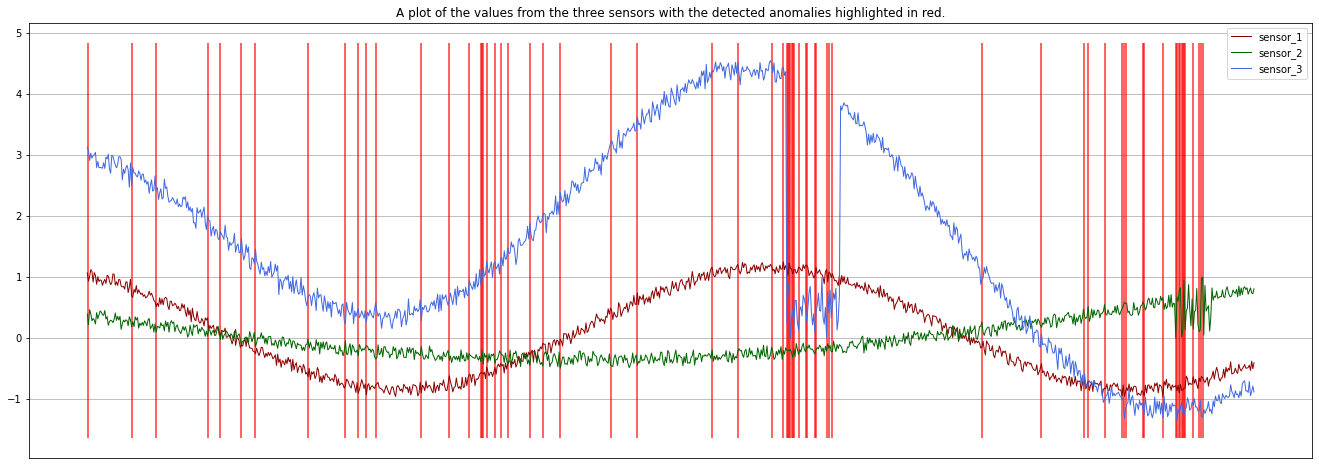

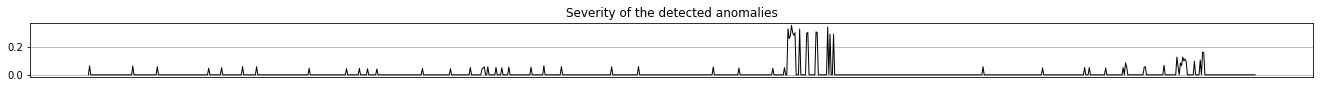

In [ ]:
plt.figure(figsize=(23,8))
plt.plot(rdf['timestamp'],rdf['sensor_1'], color='darkred', linestyle='solid', linewidth=1, label='sensor_1')
plt.plot(rdf['timestamp'],rdf['sensor_2'], color='darkgreen', linestyle='solid', linewidth=1, label='sensor_2')
plt.plot(rdf['timestamp'],rdf['sensor_3'], color='royalblue', linestyle='solid', linewidth=1, label='sensor_3')
plt.grid(axis='y')
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.legend()

anoms = list(rdf["isAnomaly"] == True)
_, _, ymin, ymax = plt.axis()
plt.vlines(np.where(anoms), ymin=ymin , ymax=ymax , color='r', alpha=0.8)

plt.legend()
plt.title('A plot of the values from the three sensors with the detected anomalies highlighted in red.')
plt.show()

plt.figure(figsize=(23,1))
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.plot(rdf['timestamp'],rdf['severity'], color='black', linestyle='solid', linewidth=1)
plt.grid(axis='y')
plt.title("Severity of the detected anomalies")
plt.show()

The two plots above show the raw data from the sensors (in the inference window) in dark red, green, and blue. The red vertical lines indicate the detected anomalies in this window, and the black line in the second plot shows the severity of each deteced anomaly.